In [1]:
import os
import numpy as np
from scipy import io
from pathlib import Path

from modules import preproc, rhino, source_recon, parcellation, hmm, utils
import mne
from osl_dynamics import inference, analysis
from osl_dynamics.utils import plotting
from osl_dynamics.data import Data

2025-12-24 22:28:44.582930: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-24 22:28:44.586745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-24 22:28:44.597591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766586524.615847 2331350 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766586524.620801 2331350 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766586524.636069 2331350 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
#preprocessing and source reconstruction
for subj_id in [f"{i:02d}" for i in range(1, 34)]:
    for task_id in [f"{i:02d}" for i in range(1, 7)]:

        out_id = f"sub-{subj_id}_ses-01_task-stim{task_id}"

        try:
            if not os.path.exists(f'prep_data/sub-{subj_id}_ses-01_task-stim{task_id}_eeg.fif'):
                print(f"[skip]: {f'prep_data/sub-{subj_id}_ses-01_task-stim{task_id}_eeg.fif'}")
                continue
            fns = utils.OSLFilenames(
                outdir="out_data",
                id=out_id,
                preproc_file=f"prep_data/sub-{subj_id}_ses-01_task-stim{task_id}_eeg.fif",
                surfaces_dir="mni152_surfaces",  # replace with the 'outdir' used in rhino.extract_surfaces if you have your own structural
            )

            rhino.extract_polhemus_from_fif(fns, include_eeg_as_headshape=True)
            rhino.coregister(
                fns,
                allow_smri_scaling=True,  # set to False if using a real structural
            )

            rhino.forward_model(fns, model="Triple Layer", gridstep=8, meg=False, eeg=True)

            fif_file = f"prep_data/sub-{subj_id}_ses-01_task-stim{task_id}_eeg.fif"
            raw = mne.io.read_raw_fif(fif_file, preload=False)

            source_recon.lcmv_beamformer(fns, raw, chantypes="eeg", rank={"eeg": 50})
            voxel_data, voxel_coords = source_recon.apply_lcmv_beamformer(fns, raw)

            parcellation_file = "fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz"

            parcel_data = parcellation.parcellate(
                fns,
                voxel_data,
                voxel_coords,
                method="spatial_basis",
                orthogonalisation="symmetric",
                parcellation_file=parcellation_file,
            )

            parcellation.save_as_fif(
                parcel_data,
                raw,
                extra_chans="stim",
                filename=f"out_data/{out_id}/lcmv-parc-raw.fif",
            )

        except Exception as e:
            print(f"[error] {out_id} with: {e}")
            continue

In [ ]:
import os

base_dir = "/out_data"

# loop range
subj_range = range(1, 33) 
task_range = range(1, 7)
target_file_name = "lcmv-parc-raw.fif"
# -----------------------

fif_files = []
for s in subj_range:
    subj_id = f"{s:02d}"
        
    for t in task_range:
        task_id = f"{t:02d}"
        out_id = f"sub-{subj_id}_ses-01_task-stim{task_id}"
        file_path = os.path.join(base_dir, out_id, target_file_name)
        
        if os.path.exists(file_path):
            fif_files.append(file_path)

data = Data(
    fif_files, 
    picks="misc", 
    reject_by_annotation="omit", 
    n_jobs=32
)

In [ ]:
data = hmm.prepare_data_for_canonical_hmm(data, parcellation="38ROI_Giles")

QUEUEING TASKS | Calculating covariances:   0%|          | 0/163 [00:00<?, ?it/s]

PROCESSING TASKS | Calculating covariances:   0%|          | 0/163 [00:00<?, ?it/s]

COLLECTING RESULTS | Calculating covariances:   0%|          | 0/163 [00:00<?, ?it/s]

2025-12-25 03:15:51 INFO osl-dynamics [base.py:1175:align_channel_signs]: Aligning channel signs across sessions


In [ ]:
model = hmm.load_canonical_hmm(n_states=6, parcellation="38ROI_Giles")
# State probability time course
alp = model.get_alpha(data)


Getting alpha:   0%|          | 0/148 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np
n_states = 6
n_sessions = len(alp)
all_fo = np.zeros([n_sessions,n_states])
all_lt =np.zeros([n_sessions,n_states])
all_intv = np.zeros([n_sessions,n_states])
all_sr = np.zeros([n_sessions,n_states])


column_names = []

for i in range(n_sessions):
    current_alp = alp[i]
    current_fif = fif_files[i]
    
    session_id = current_fif.split('/')[-2]
    column_names.append(session_id)
    
    alp_raw = inference.modes.convert_to_mne_raw(current_alp, current_fif, n_embeddings=data.n_embeddings, verbose=False)
    fs = alp_raw.info["sfreq"]
    
    # HMM features
    stc = inference.modes.argmax_time_courses(current_alp)
    all_fo[i,:] = analysis.post_hoc.fractional_occupancies(stc)
    all_lt[i,:] = analysis.post_hoc.mean_lifetimes(stc, sampling_frequency=fs)
    all_intv[i,:] = analysis.post_hoc.mean_intervals(stc, sampling_frequency=fs)
    all_sr[i,:] = analysis.post_hoc.switching_rates(stc, sampling_frequency=fs)

# Export
state_labels = [f"State {j}" for j in range(n_states)]

df_fo = pd.DataFrame(all_fo)
df_lt = pd.DataFrame(all_lt)
df_intv = pd.DataFrame(all_intv)
df_sr = pd.DataFrame(all_sr)
df_fo.to_csv("HMM_FO.csv")
df_lt.to_csv("HMM_Lifetimes.csv")
df_intv.to_csv("HMM_Intervals.csv")
df_sr.to_csv("HMM_SwitchingRates.csv")



In [ ]:
parcellation = "38ROI_Giles"
n_states=6
plots_dir = f"plots/{n_states}_states_{parcellation}"
hmm.plot_canonical_group_level_networks(n_states=n_states, parcellation=parcellation, plots_dir=plots_dir)
hmm.display_network_plots(n_states=n_states, plots_dir=plots_dir)

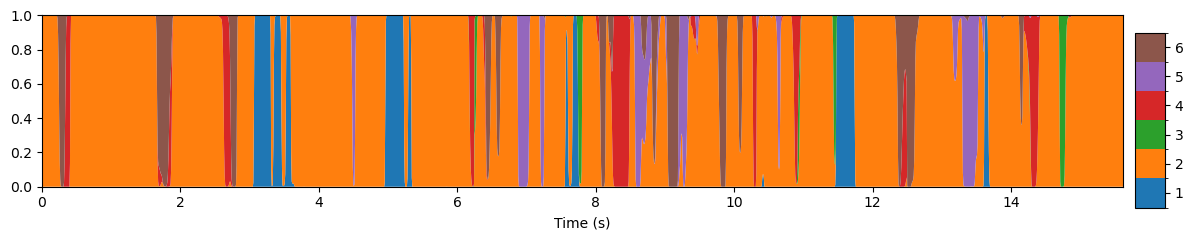

In [ ]:
first_alp = alp[0]
first_fif = fif_files[0]

alp_raw = inference.modes.convert_to_mne_raw(
    first_alp, 
    first_fif, 
    n_embeddings=data.n_embeddings
)

fig, ax = plotting.plot_alpha(
    first_alp, 
    n_samples=2000, 
    sampling_frequency=alp_raw.info["sfreq"]
)